---
title: Practice Activity 7.2
author: "Deepika Agarwal"
format:
  html:
    embed-resources: true
echo: true
---


In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from plotnine import *

In [4]:
ames = pd.read_csv("AmesHousing.csv")
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [5]:
# Get rid of columns with NaN values more than 100
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [6]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

In [7]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

In [8]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [9]:
lr_scores = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'r2')
lr_scores.mean()

np.float64(0.8538898800207827)

In [10]:
lr_pipeline_fitted = lr_pipeline.fit(X,y)

In [11]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

In [12]:
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
ridge_scores.mean()

np.float64(0.8619316345217335)

Analysis: Ridge Regression performs better than Linear Regression because it has a higher Rsquare value. This means Ridge explains more variance in the data and generalizes better. The improvement happens because Ridge uses L2 regularization which reduces overfitting by shrinking large coefficients and stabilizing the model.

In [13]:
ridge_pipeline_fitted = ridge_pipeline.fit(X, y)

In [14]:
coef_compare = pd.DataFrame()

coef_compare["lr"] = lr_pipeline_fitted.named_steps['linear_regression'].coef_
coef_compare["ridge"] = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_
coef_compare["diff"] = coef_compare["lr"] - coef_compare["ridge"]

In [15]:
coef_compare.sort_values(by = "diff")

,lr,ridge,diff
91,-559653.342134,-233156.089658,-326497.252476
68,-113384.181772,-77996.160321,-35388.021451
106,-33825.937758,-16633.220977,-17192.716782
85,-20968.886474,-6399.635769,-14569.250704
124,-17416.886121,-6826.403541,-10590.482579
...,...,...,...
95,55399.766568,16828.505080,38571.261487
69,64910.291903,24567.527777,40342.764126
37,127054.304996,66530.685838,60523.619159
94,109059.255835,28387.663156,80671.592679


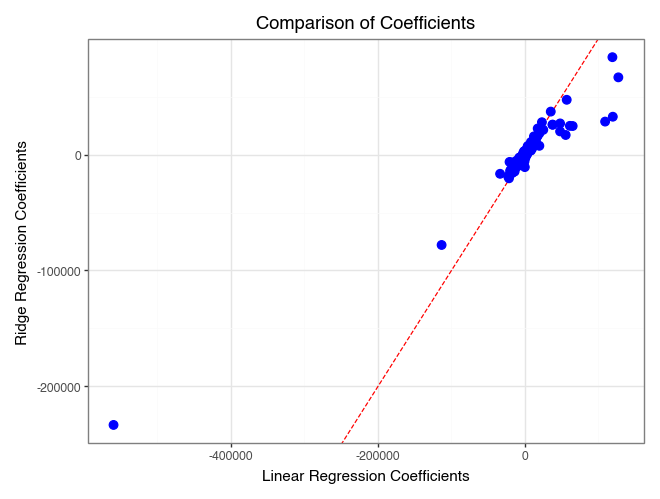

In [16]:
plot = (
    ggplot(coef_compare, aes(x='lr', y='ridge')) +
    geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
    geom_point(color='blue', size=3) +
    labs(
        title='Comparison of Coefficients',
        x='Linear Regression Coefficients',
        y='Ridge Regression Coefficients'
    ) +
    theme_bw()
)

plot

Analysis: The plot shows that Ridge Regression coefficients are smaller than those from Linear Regression. This happens because Ridge uses L2 regularization, which shrinks large coefficients toward zero, making the model more stable and less prone to overfitting.

# Practice Activity: 2

Using the same pipeline as previously, perform tuning on λ.

You should always try λ values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [17]:
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
).set_output(transform="pandas")

alphas = {'ridge_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_ridge = GridSearchCV(ridge_pipeline_1, param_grid=alphas, cv = 5, scoring='r2', n_jobs=-1)

In [18]:
gscv_fitted_ridge = gscv_ridge.fit(X, y)

In [19]:
df_cv_results_ridge = pd.DataFrame(gscv_fitted_ridge.cv_results_)

df_cv_results_ridge

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039964,0.011010,0.015543,0.004134,100.00,{'ridge_regression__alpha': 100.0},0.887765,0.921979,0.793420,0.772149,0.913554,0.857773,0.062620,3
1,0.042362,0.015357,0.015323,0.004048,10.00,{'ridge_regression__alpha': 10.0},0.897762,0.920812,0.800572,0.787120,0.915095,0.864272,0.058157,1
2,0.037822,0.008132,0.008497,0.002116,1.00,{'ridge_regression__alpha': 1.0},0.898158,0.917440,0.794936,0.785226,0.913898,0.861932,0.059104,2
3,0.036205,0.007892,0.012790,0.005092,0.10,{'ridge_regression__alpha': 0.1},0.897744,0.912306,0.790110,0.775764,0.905587,0.856302,0.060250,4
4,0.025582,0.002610,0.007545,0.000976,0.01,{'ridge_regression__alpha': 0.01},0.897343,0.910614,0.789126,0.772532,0.901317,0.854186,0.060280,5


In [20]:
gscv_fitted_ridge.best_params_

{'ridge_regression__alpha': np.float64(10.0)}

In [21]:
gscv_fitted_ridge.best_score_

np.float64(0.8642722110166746)

# Practice Activity: 3

Create a LASSO pipeline, and tune λ.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [22]:
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': np.array([100, 10, 1, 0.1, 0.01])}

gscv_lasso = GridSearchCV(lasso_pipeline_1, param_grid=alphas, cv = 5, scoring='r2', n_jobs=-1)

In [23]:
gscv_fitted_lasso = gscv_lasso.fit(X, y)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+11, toler

In [24]:
df_cv_results_lasso= pd.DataFrame(gscv_fitted_lasso.cv_results_)

df_cv_results_lasso

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.134419,0.021002,0.010546,0.001202,100.00,{'lasso_regression__alpha': 100.0},0.901800,0.924433,0.805390,0.783485,0.919547,0.866931,0.060069,1
1,0.208009,0.104578,0.017240,0.006045,10.00,{'lasso_regression__alpha': 10.0},0.900776,0.915067,0.801420,0.776649,0.909250,0.860632,0.059157,2
2,1.872371,1.143296,0.129808,0.059128,1.00,{'lasso_regression__alpha': 1.0},0.897744,0.910938,0.796918,0.774262,0.905899,0.857152,0.059018,3
3,6.319786,1.523368,0.279104,0.189817,0.10,{'lasso_regression__alpha': 0.1},0.897258,0.910451,0.795951,0.774072,0.905360,0.856618,0.059025,4
4,8.188613,0.817850,0.276873,0.148460,0.01,{'lasso_regression__alpha': 0.01},0.897206,0.910401,0.790859,0.774060,0.905502,0.855606,0.060107,5


In [25]:
gscv_fitted_lasso.best_params_

{'lasso_regression__alpha': np.float64(100.0)}

In [26]:
gscv_fitted_lasso.best_score_

np.float64(0.8669311075511448)

In [27]:
ridge_coef = gscv_fitted_ridge.best_estimator_.named_steps['ridge_regression'].coef_
lasso_coef = gscv_fitted_lasso.best_estimator_.named_steps['lasso_regression'].coef_

coef_df = pd.DataFrame()

coef_df["lr"] = lr_pipeline_fitted.named_steps['linear_regression'].coef_
coef_df["ridge"] = ridge_coef
coef_df["lasso"] = lasso_coef

coef_df

,lr,ridge,lasso
0,-4648.554959,-4906.494598,-0.000000
1,1546.687999,2346.943135,0.000000
2,-7516.051924,-1229.177404,-0.000000
3,7867.442231,4620.911891,0.000000
4,3774.440540,2204.285000,0.000000
...,...,...,...
249,2670.612233,3104.701760,2829.886060
250,2776.215267,489.258612,791.915349
251,-5139.727420,-4135.488058,-4328.443776
252,-774.812417,-638.220273,-576.052919


In [28]:
(coef_df["lasso"] == 0).sum()

np.int64(163)

In [29]:
(coef_df["ridge"] == 0).sum()

np.int64(0)

Anlaysis: The dataframe shows that Ridge coefficients are smaller than Linear Regression due to L2 regularization, which reduces overfitting. Lasso goes further with L1 regularization, setting 163 out of 254 coefficients to zero, effectively selecting key features and simplifying the model.

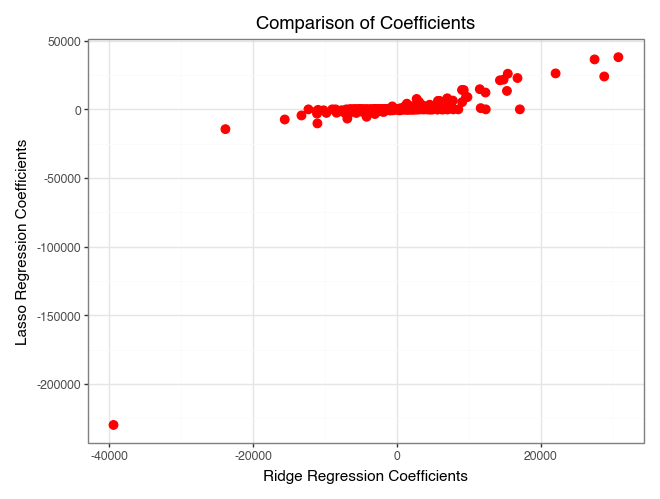

In [30]:
plot = (
    ggplot(coef_df, aes(x='ridge', y='lasso')) +
    geom_point(color='red', size=3) +
    labs(
        title='Comparison of Coefficients',
        x='Ridge Regression Coefficients',
        y='Lasso Regression Coefficients'
    ) +
    theme_bw()
)

plot

Analysis: The plot shows that most of the Lasso coefficients are zero, while Ridge keeps small nonzero values. This means Lasso removes less important features to make the model simpler, while Ridge keeps all features but makes their values smaller.

# Practice Activity: 4
Create an Elastic Net pipeline, and tune λ and α.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [31]:
elastic_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
).set_output(transform="pandas")

param_grid = {
    "elastic_net__alpha": [100, 10, 1, 0.1, 0.01],
    "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2),
}

gscv_elastic = GridSearchCV(elastic_pipeline_1, param_grid=param_grid, cv = 5, scoring='r2', n_jobs = -1, verbose = 1)

In [32]:
gscv_fitted_elastic = gscv_elastic.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.372e+12, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.960e+12, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

In [33]:
df_cv_results_elastic = pd.DataFrame(gscv_fitted_elastic.cv_results_)

df_cv_results_elastic

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic_net__alpha,param_elastic_net__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.099353,0.184961,0.078556,0.020863,100.00,0.0,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",0.068602,0.114533,0.107924,0.102946,0.105640,0.099929,0.016126,30
1,0.735556,0.090153,0.098475,0.077092,100.00,0.2,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",0.090762,0.139899,0.132094,0.125232,0.130752,0.123748,0.017145,29
2,0.482855,0.212672,0.126260,0.059934,100.00,0.4,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",0.125392,0.179344,0.169608,0.159851,0.169794,0.160798,0.018745,28
3,0.441589,0.199112,0.113518,0.029247,100.00,0.6,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",0.187065,0.248971,0.235584,0.220823,0.238682,0.226225,0.021554,27
4,0.218410,0.028490,0.084411,0.015165,100.00,0.8,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",0.326931,0.403467,0.380581,0.355303,0.391397,0.371536,0.027382,26
5,0.985579,0.132381,0.072317,0.012869,100.00,1.0,"{'elastic_net__alpha': 100, 'elastic_net__l1_r...",0.901800,0.924433,0.805390,0.783485,0.919547,0.866931,0.060069,1
6,3.819300,0.209461,0.068532,0.019165,10.00,0.0,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.492511,0.578344,0.541161,0.505391,0.563972,0.536276,0.032954,25
7,0.208285,0.020300,0.117551,0.045386,10.00,0.2,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.543978,0.630330,0.587613,0.549154,0.615216,0.585258,0.034473,24
8,0.255570,0.058557,0.070383,0.010436,10.00,0.4,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.605470,0.690470,0.640126,0.598959,0.674490,0.641903,0.036319,23
9,0.222959,0.016356,0.083863,0.025677,10.00,0.6,"{'elastic_net__alpha': 10, 'elastic_net__l1_ra...",0.679356,0.759111,0.697470,0.654039,0.742257,0.706446,0.039030,22


In [34]:
gscv_fitted_elastic.best_params_

{'elastic_net__alpha': 100, 'elastic_net__l1_ratio': np.float64(1.0)}

In [35]:
gscv_fitted_elastic.best_score_

np.float64(0.8669311075511448)

In [36]:
elastic_coef = gscv_fitted_elastic.best_estimator_.named_steps['elastic_net'].coef_
coef_df['elastic'] = elastic_coef
coef_df

,lr,ridge,lasso,elastic
0,-4648.554959,-4906.494598,-0.000000,-0.000000
1,1546.687999,2346.943135,0.000000,0.000000
2,-7516.051924,-1229.177404,-0.000000,-0.000000
3,7867.442231,4620.911891,0.000000,0.000000
4,3774.440540,2204.285000,0.000000,0.000000
...,...,...,...,...
249,2670.612233,3104.701760,2829.886060,2829.886060
250,2776.215267,489.258612,791.915349,791.915349
251,-5139.727420,-4135.488058,-4328.443776,-4328.443776
252,-774.812417,-638.220273,-576.052919,-576.052919


Analysis: The table shows coefficients from Linear, Ridge, Lasso, and Elastic Net models. Since the Elastic Net’s L1 ratio is 1.0, the Ridge part becomes zero, so it behaves just like Lasso. This means it sets many coefficients to zero and removes less important features.